# Setup and Import

We import our necessary functions from Python, Numpy, Pandas, Matplotlib, Scikit-learn, and Keras.

In [ ]:
# Base Packages
import numpy as np
import pandas as pd

# Python, Numpy, Pandas, and Matplotlib
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

#Scikit-learn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Function to Create Lag Variables

We need to create a function that allows us to convert our monthly observation data to time series data with a user-specified number of lags that can ultimately be used for supervised learning.

In [ ]:
def create_lagged(data, lookback_period=1, forecast_period=1, dropnan=True):
    # Specify number of variables
    if type(data) is list:
        n_vars = 1
    else:
        n_vars = data.shape[1]
    df = pd.DataFrame(data)
    columns, column_names = [], []

    # Input Sequence (t-n, ... , t-2, t-1)
    for i in range(lookback_period, 0, -1):
        columns.append(df.shift(i))
        column_names += [('var%d(t-%d)' % (j+1, i)) for j in range (n_vars)]
    
    # Prediction Sequence (t, t+1, t+2, ... , t+n)
    for i in range(0, forecast_period):
        columns.append(df.shift(-i))
        if i == 0:
            column_names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            column_names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Concatenation of Columns
    agg = concat(columns, axis=1)
    agg.columns = column_names

    # If have NaN values, Drop Row
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Preprocessing Data

#### Choose whether to run on Google Colab or local machine


* **Choice 1**: Colab



* **Choice 2**: Local Machine

**UNCOMMENT** the CHOICE that you would like to do.



In [ ]:
### CHOICE 1: COLAB
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

dataset = pd.read_csv('/content/gdrive/MyDrive/SuperModels-Data-X/TS_ALL.csv')

Mounted at /content/gdrive


In [ ]:
# ### CHOICE 2: LOCAL
# ## Choose Which File to Upload
# # dataset = pd.read_csv('Downloads/example.csv')
# dataset = pd.read_csv('Downloads/TS.csv')

#### Initial Dataset (For Reference)
After importing, we look at a quick preview of our dataset. The variables provides are user_id (unique to each user), campaign_name (how each user signed up for SaverLife), year_month (a string that shows the date of the observation row), income (monthly income for the month specified), spending (monthly spending for the month specified), spend_trans (the number of transactions for the month specified), balance (the total balance for the user across all accounts, i.e. checking, savings, etc.), and events (and internal measure by SaverLife that aggregates such things as the the number of times that a user interacts with SaverLife's app and the number of clicks on the website for the month specified).

In [ ]:
dataset.shape

(280125, 8)

In [ ]:
dataset.head()

In [ ]:
dataset.describe()

,user_id,income,spending,spend_trans,balance,events
count,280125.000000,2.801250e+05,2.801250e+05,280125.000000,2.800490e+05,174063.000000
mean,273124.329639,-3.198280e+05,3.284611e+05,51.779113,1.073683e+05,16.506569
std,123316.074788,4.117557e+05,4.418969e+05,51.382517,7.613611e+05,59.108416
min,76.000000,-1.874233e+07,0.000000e+00,0.000000,-2.443409e+07,1.000000
25%,158130.000000,-4.316770e+05,6.019400e+04,12.000000,-6.277000e+03,2.000000
50%,291976.000000,-2.000000e+05,2.069170e+05,38.000000,7.119000e+03,3.000000
75%,359140.000000,-5.344700e+04,4.390960e+05,76.000000,7.866000e+04,7.000000
max,517273.000000,0.000000e+00,2.306470e+07,906.000000,8.866409e+07,7461.000000


#### Add New Columns to Dataset

We add a new column for 'Net Savings.' This is calculated as the difference between each month's income and each month's spending.

In [ ]:
# Add Net Savings Column
dataset['net_savings'] = abs(dataset['income']) - dataset['spending']
dataset['net_savings'] = dataset['net_savings'].astype('int')

SaverLife stores income and spending amounts in cents. For ease of interpretation, we converts all columns whose units are specified in cents to dollars.

In [ ]:
# Convert cents to dollars
dataset['income'] = -dataset['income'] / 100
dataset['net_savings'] = dataset['net_savings'] / 100
dataset['spending'] = -dataset['spending'] / 100
dataset['balance'] = dataset['balance'] / 100

We also create new categorical variables that specify year and month.

In [ ]:
# Add Year and Month Columns
dataset[['year', 'month']] = dataset['year_month'].str.split("_", expand=True)
dataset['year'] = dataset['year'].astype('int')
dataset['month'] = dataset['month'].astype('int')

Finally, we specify a dummy variable for a certain user sign-up method that SaverLife had of interest. Partner A is an application that people can use to check their available balance of Partner A. Partner A and SaverLife have been working together, and a large subset of users have signed up for SaverLife through Partner A.

In [ ]:
# Add Binary Variable for Partner A Campaign (aka Partner A)
def ebt_yn(campaign):
    if campaign =='Partner A':
        return 1
    else:
        return 0
dataset['Partner A'] = dataset['campaign_name'].apply(ebt_yn)

#### Convert Certain Fields to Integers and Select only Checking Accounts

To calculate our lagged variables, our data must be sorted in a particular manner. Monthly observations must be sorted by User, and must be sorted by date ascending from earliest to most recent. We also group by columns user_id, year, and month because some users have multiple observations for each month because of having multiple accounts.

In [ ]:
dataset = dataset.sort_values(['user_id', 'year', 'month'], ascending = (True, True, True))
dataset = dataset.groupby(['user_id', 'year', 'month', 'Partner A']).first().reset_index()
dataset = dataset.iloc[0:55000,]

dataset.head()

For record keeping purposes, we export a csv of our current dataframe.

In [ ]:
dataset.to_csv('/content/gdrive/MyDrive/SuperModels-Data-X/ts_combined_duplicates.csv', index=False)

#### Create Dummy Variables for Month, Year

We convert our categorical variables for month (January to December) and year (2019 to 2021) to 11 dummy variables for month and 2 dummy variables for year.

In [ ]:
dataset = pd.get_dummies(data=dataset, columns=['month', 'year'], drop_first=True,)

#### Decide Population of Users to Keep in Dataset

Next, we also import a dataset that provides of list of users that have contiguous time series data for at least 4 months. We provide 

In [ ]:
contiguous = pd.read_csv('/content/gdrive/MyDrive/SuperModels-Data-X/user_contiguous.csv')
contiguous = pd.unique(contiguous["user_contiguous"])

Create list of unique users. We also print the number of users in the full dataset versus the dataset subset that only has users with contiguous time series data for at least 4 months.

In [ ]:
unique_ids = pd.unique(dataset['user_id'])
print(f"We have {len(contiguous)} unique user_id's that have contiguous data for at least 4 months and {len(unique_ids)} unique user_id's in the entire dataset.")

We have 20712 unique user_id's that have contiguous data for at least 4 months and 3135 unique user_id's in the entire dataset.


We do a quick sanity check to see that the number of unique user_id's increases each year. We also save down the original list of columns for our dataset for reference later.

In [ ]:
orig_columns = dataset.columns
dataset.groupby(['year_2020','year_2021']).agg({'user_id':'count'})

user_id
year_2020 year_2021         
0         0            21746
          1            10865
1         0            22389

Create list of dataframes by User. We provide two options. One is to return all unqiue users. The other is to return only users with consecutive time observations (i.e. no missing months)

* **Choice 1**: Keep all user_id's in the dataset to train the model.



* **Choice 2**: Keep ONLY user_id's with consecutive data for at least 4 months in the dataset to train the model.

Using this choice, we create a list of dataframes. Each dataframe contains the observations for a certain user_id. This allows us to create the lag variables correctly. For example, if we created the lag variables without separating by user, the algorithm would not know when to stop creating lag variables when moving to the next user_id.

**UNCOMMENT** the CHOICE that you would like to do.


In [ ]:
# CHOICE 1: Choose List of All Unique UserIDs 
df_list = []
for i in unique_ids:
    df_list.append(dataset[dataset['user_id']==i])

In [ ]:
# # CHOICE 2: Choose List of UserIDs that have contiguous times series data
# df_list = []
# for i in contiguous:
#     df_list.append(dataset[dataset['user_id']==i])

We do a sanity check to show that each user has a different number of monthly observations for the shared number of variables.

In [ ]:
pd.concat(df_list).shape

(55000, 23)

In [ ]:
for i,x in enumerate(df_list):
    if (i < 10):
        print(x.shape)
    else:
        break

(9, 23)
(7, 23)
(7, 23)
(15, 23)
(24, 23)
(23, 23)
(24, 23)
(4, 23)
(8, 23)
(6, 23)


#### Check to see how many months of data the minimum user has
When we set the lookback period, we must have the following hold: $$Lookback\ Period + 1  \leq Minimum \ Number \ of \ Months \ of \ Consecutive \ Data$$

In [ ]:
# Initialize minimum months of data arbitrarily to 24 months
min_months = 24
min_delete = 4
# Find the actual minimum
for i,x in enumerate(df_list):
    if (df_list[i].shape[0] < min_months):
        min_months = df_list[i].shape[0]
    if (df_list[i].shape[0] < min_delete):
        del(df_list[i])
print(f"We have at least {min_months} consecutive data for all users.")

We have at least 4 consecutive data for all users.


#### Rearrange columns and select columns to keep for LSTM

First, we show  a list of columns that we can select from to train our model.

In [ ]:
orig_columns

Next, we manually add variables that we would like to keep. 

**Make sure the first variable in the list is the desired dependent variable.**

Additionally, designate the last variable as the 'user_id' variable, as we will be removing this variable before training the model, but then re-adding the variable to keep the model's predictions associated with the correct user_id.

For example, we designate the first variable as the 'balance' and the last variable as 'user_id'.

In [ ]:
# Remove certain Columns, Keep desired columns
for i, x in enumerate(df_list):
    df_list[i] = df_list[i][['balance', 
                             'events', 
                             'Partner A',
                             'income', 
                             'spending',
                             'spend_trans', 
                             'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 
                             'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
                             'year_2020', 'year_2021', 'user_id']]

For reference, we present a ordered list of our variables from 1 to n. We remind that variable 1 should be our target variable and variable n should be user_id.

In [ ]:
# Get a list of numbered column names
rank = []
for i, x in enumerate(df_list[0].columns):
    rank.append((i+1, df_list[0].columns[i]))
print('Column names before removing user_id')
rank

#### Create Dataset Checks for Lagged Variable Creation

When we create our lagged dataset, this new dataset will have fewer rows that our original dataset. For example, if we have a dataset of 10 rows, each specifying a different month. If we create a lagged dataset with a lookback of 3 periods to project the next period, we will transform a dataset with 10 rows into a dataset with 7 rows (but with more columns). We create a groupby object to be able to compare to after creating our lagged dataset.

In [ ]:
# # Uncomment to Skip and Save Time
# # Create GroupBy Object to count the nubmer of observations for 2021, February through May
# pd.concat(df_list).groupby(['year_2021','month_2',	"month_3",	"month_4",	"month_5"]).agg({'balance':'count'})

# Motivation for Using Recurrent Neural Networks (LSTM Networks)

Recurrent neural netowrks (RNNs) will allow us to caputure the time series nature our our user saving and spending data. A regular neural network would treat each time step independently, ingorning the fact that our data is ordered sequentially. Thus, our RNN will be to "aggregate information" about what it has seen before as each additional sequence of elements is passed through the RNN.

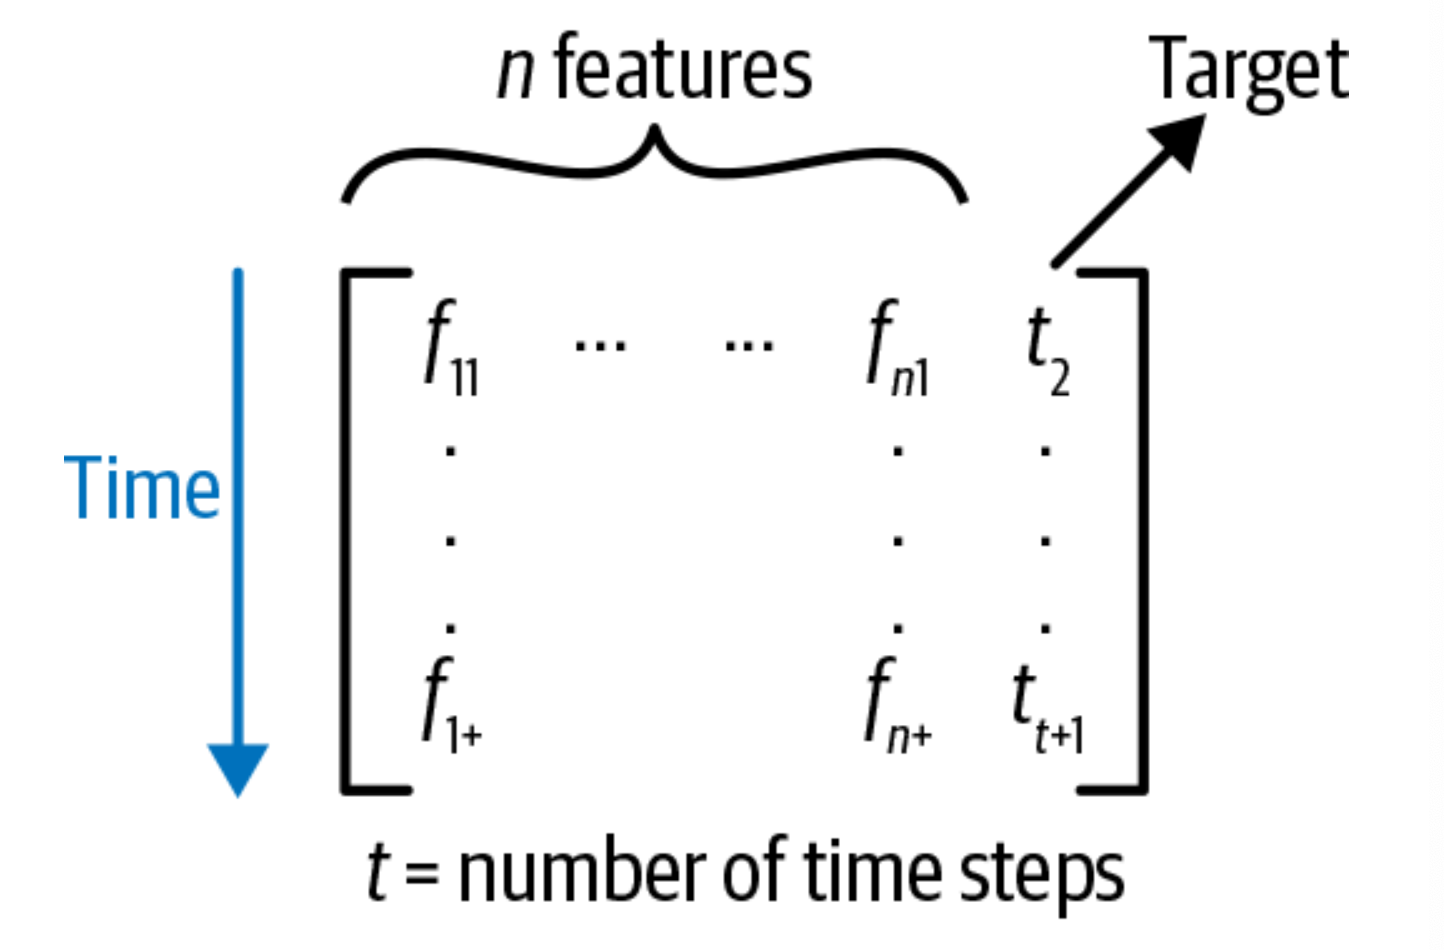

# Create the Lagged Dataset to pass to our LSTM Network

We must now specify what lookback period and forecast period we want for our lagged dataset. We will choose a lookback period of 3 and a forecast period of 1. Thus, for every user_id, we will be using previous 3 month periods (e.g. t-3, t-2, and t-1) to predict the next period (e.g. t).

In [ ]:
# CHOOSE INPUTS
_lookback = 3 
_forward = 1 

In [ ]:
df_LSTM = []
_n_features = len(df_list[0].columns)
print(f'We have {_n_features} variables that will be lagged {_lookback} times')

for i,x in enumerate(df_list):
    reframed = create_lagged(x, _lookback, _forward)
    df_LSTM.append(reframed)
df_LSTM = pd.concat(df_LSTM)

We have 20 variables that will be lagged 3 times


#### Dataset Check for Lagged Variable Creation, Continued from above
We create the same groupby object (e.g. Year 2021, February through April), but for our new dataset. We expect the number of observations for each row to decrease by 20-40% given our choices for our lookback period and our forecast period.

For reference:
*   (19, 'year_2021')
*   (7, 'month_2')
*   (8, 'month_3')
*   (9, 'month_4'),



 

In [ ]:
# # Uncomment to Skip and Save Time
# df_LSTM.groupby(['var19(t)','var7(t)','var8(t)','var9(t)', 
#                  'var10(t)']).agg({'var1(t)':'count'})

In [ ]:
df_LSTM

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var14(t-3),var15(t-3),var16(t-3),var17(t-3),var18(t-3),var19(t-3),var20(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var16(t-2),var17(t-2),var18(t-2),var19(t-2),var20(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t)
81,-383.28,3.0,1.0,1907.52,-1916.41,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,247.0,-392.17,2.0,1.0,3480.34,-3240.13,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,247.0,-151.96,6.0,1.0,1462.11,-1569.33,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,247.0,-259.18,2.0,1,1592.80,-1619.92,39,1,0,0,0,0,0,0,0,0,0,0,0,1,247
82,-392.17,2.0,1.0,3480.34,-3240.13,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,247.0,-151.96,6.0,1.0,1462.11,-1569.33,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,247.0,-259.18,2.0,1.0,1592.80,-1619.92,39.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,247.0,-286.30,3.0,1,1785.27,-1688.43,47,0,1,0,0,0,0,0,0,0,0,0,0,1,247
83,-151.96,6.0,1.0,1462.11,-1569.33,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,247.0,-259.18,2.0,1.0,1592.80,-1619.92,39.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,247.0,-286.30,3.0,1.0,1785.27,-1688.43,47.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,247.0,-189.46,2.0,1,1614.73,-1755.59,48,0,0,1,0,0,0,0,0,0,0,0,0,1,247
105,13858.02,2.0,1.0,3499.10,-3954.26,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,259.0,13402.86,4.0,1.0,3512.67,-3534.66,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,259.0,13380.87,1.0,1.0,4342.12,-4161.77,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,259.0,13561.22,5.0,1,3399.47,-2147.99,49,1,0,0,0,0,0,0,0,0,0,0,0,1,259
106,13402.86,4.0,1.0,3512.67,-3534.66,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,259.0,13380.87,1.0,1.0,4342.12,-4161.77,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,259.0,13561.22,5.0,1.0,3399.47,-2147.99,49.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,259.0,14812.70,2.0,1,2005.10,-11406.76,147,0,1,0,0,0,0,0,0,0,0,0,0,1,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54979,193.96,4.0,0.0,4121.20,-3067.12,97.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,144478.0,1248.04,59.0,0.0,2669.22,-3684.17,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,144478.0,233.09,22.0,0.0,4494.02,-3687.00,127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,144478.0,1040.11,1.0,0,3631.18,-4327.10,120,0,0,0,0,0,0,0,0,0,0,0,0,1,144478
54980,1248.04,59.0,0.0,2669.22,-3684.17,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,144478.0,233.09,22.0,0.0,4494.02,-3687.00,127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,144478.0,1040.11,1.0,0.0,3631.18,-4327.10,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,144478.0,344.19,6.0,0,4689.90,-4619.49,114,1,0,0,0,0,0,0,0,0,0,0,0,1,144478
54981,233.09,22.0,0.0,4494.02,-3687.00,127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,144478.0,1040.11,1.0,0.0,3631.18,-4327.10,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,144478.0,344.19,6.0,0.0,4689.90,-4619.49,114.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,144478.0,414.60,3.0,0,4903.16,-4751.34,16

In [ ]:
dataset.describe()

In [ ]:
df_LSTM.describe()

In [ ]:
pd.concat(df_list).describe()

#### Save User ID's for Lagged Dataframe to Re-attach Later

We drop user_id's from our LSTM Dataframe. This is because, we don not want to train on this features. However, we will save them in a separate dataframe so we can re-assign our model's predictions to the right user_id and month.

In [ ]:
# Specify variables to help us drop superfluous variables
if _lookback == 3:
    time_var = ['(t)', '(t-1)', '(t-2)', '(t-3)']
if _lookback == 4:
    time_var = ['(t)', '(t-1)', '(t-2)', '(t-3)', '(t-4)']
if _lookback == 5:
    time_var = ['(t)', '(t-1)', '(t-2)', '(t-3)', '(t-4)', '(t-5)']
if _lookback == 6:
    time_var = ['(t)', '(t-1)', '(t-2)', '(t-3)', '(t-4)', '(t-5)', '(t-6)']

txt_var = 'var'
idlabels = []
for i in time_var:
    idlabels.append(txt_var+str(_n_features)+i)

currentlabels = []
for i in range(2, _n_features):
    currentlabels.append(txt_var+str(i)+time_var[0])

Find all user_id varialbes. Save them and remove them from the dataframe we will pass through our recurrent neural network.

In [ ]:
df_userIDs_lag = df_LSTM[idlabels].copy()
df_LSTM = df_LSTM.drop(idlabels, axis=1)
df_userIDs_lag = df_userIDs_lag.drop(idlabels[1:], axis=1)

Remove all other variables for time t, leaving only the dependent variable of interest.

In [ ]:
df_extra_lag = df_LSTM[currentlabels].copy()
df_LSTM = df_LSTM.drop(currentlabels, axis=1)

After dropping the User_ID Column and saving it separatedly, we are left with the updated df_LSTM dataframe to next scale the features

# Scaling Features

After dropping all UserIDs, convert DataFrame to Values and run MinMaxScaler. We choose MinMaxScaler because it is one of the simplest, using the minimum and maximum values of a feature to rescale values to be within a certain range (in our case, between 0 and 1).

In [ ]:
values = df_LSTM.values
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

Convert scaled values to a scaled Dataframe

In [ ]:
df_LSTM_scaled = pd.DataFrame(scaled, columns=df_LSTM.columns, index=df_LSTM.index)

We provide for reference and confirmation both the unscaled and scaled dataframes.

In [ ]:
# Unscaled
df_LSTM.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var14(t-3),var15(t-3),var16(t-3),var17(t-3),var18(t-3),var19(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var16(t-2),var17(t-2),var18(t-2),var19(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var1(t)
81,-383.28,3.0,1.0,1907.52,-1916.41,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-392.17,2.0,1.0,3480.34,-3240.13,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-151.96,6.0,1.0,1462.11,-1569.33,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-259.18
82,-392.17,2.0,1.0,3480.34,-3240.13,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-151.96,6.0,1.0,1462.11,-1569.33,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-259.18,2.0,1.0,1592.80,-1619.92,39.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-286.30
83,-151.96,6.0,1.0,1462.11,-1569.33,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-259.18,2.0,1.0,1592.80,-1619.92,39.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-286.30,3.0,1.0,1785.27,-1688.43,47.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-189.46
105,13858.02,2.0,1.0,3499.10,-3954.26,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,13402.86,4.0,1.0,3512.67,-3534.66,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,13380.87,1.0,1.0,4342.12,-4161.77,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13561.22
106,13402.86,4.0,1.0,3512.67,-3534.66,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,13380.87,1.0,1.0,4342.12,-4161.77,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13561.22,5.0,1.0,3399.47,-2147.99,49.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14812.70


In [ ]:
# Scaled
df_LSTM_scaled.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var14(t-3),var15(t-3),var16(t-3),var17(t-3),var18(t-3),var19(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var16(t-2),var17(t-2),var18(t-2),var19(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var1(t)
81,0.174569,0.000951,1.0,0.032312,0.966422,0.038259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.194475,0.000441,1.0,0.058954,0.943229,0.105566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.194247,0.002207,1.0,0.034266,0.972503,0.046065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.193885
82,0.174538,0.000476,1.0,0.058954,0.943229,0.072559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.195292,0.002207,1.0,0.024767,0.972503,0.046065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.193885,0.000441,1.0,0.037329,0.971617,0.074856,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.193793
83,0.175374,0.002378,1.0,0.024767,0.972503,0.031662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.194927,0.000441,1.0,0.026981,0.971617,0.074856,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.193793,0.000883,1.0,0.041840,0.970417,0.090211,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.194121
105,0.224128,0.000476,1.0,0.059271,0.930716,0.102902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.241376,0.001324,1.0,0.059501,0.938068,0.151631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.240011,0.000000,1.0,0.101762,0.927081,0.170825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.240621
106,0.222544,0.001427,1.0,0.059501,0.938068,0.104222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.241301,0.000000,1.0,0.073551,0.927081,0.170825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.240621,0.001765,1.0,0.079670,0.962365,0.094050,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.244853


We check that shapes of both dataframes are the same.

In [ ]:
print("Sizes of scaled and unscaled dataframes must be the same:\n", df_LSTM.shape==df_LSTM_scaled.shape)

Sizes of scaled and unscaled dataframes must be the same:
 True


# Create Training and Test Sets

Choose what percentage of our data to save for our test set.

In [ ]:
# CHOOSE INPUT
train_percentage = 0.74

Select Size of Test Set

In [ ]:
values = df_LSTM_scaled.values
train_idx = int(train_percentage * df_LSTM_scaled.shape[0])
train_idx

4627

Create Train and Test Sets

In [ ]:
train = values[:train_idx,]
test = values[train_idx:,]
train.shape, test.shape

((4627, 58), (1627, 58))

For each of Train and Test Sets, create inputs and outputs

In [ ]:
_observations = _lookback * (_n_features-1)

train_x = train[:,:_observations]
# train_y = train[:,-(_n_features-1)]
train_y = train[:,-1]

test_x = test[:,:_observations]
# test_y = test[:,-(_n_features-1)]
test_y = test[:,-1]

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(4627, 57) (4627,)
(1627, 57) (1627,)


#### Choose whether we used trained on a single lag timestep or multiple lagged timesteps

* **Choice 1**: Keep all user_id's in the dataset to train the model.



* **Choice 2**: Keep ONLY user_id's with consecutive data for at least 4 months in the dataset to train the model.

In [ ]:
# CHOICE 1 - for Single Lag Input Steps
# train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
# test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
# print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

In [ ]:
# CHOICE 2 - for Multiple Lag Input Steps
train_x = train_x.reshape((train_x.shape[0], _lookback, _n_features-1))
test_x = test_x.reshape((test_x.shape[0], _lookback, _n_features-1))
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(4627, 3, 19) (4627,) (1627, 3, 19) (1627,)


# Training Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal, GlorotNormal
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.backend import clear_session

In [ ]:
clear_session()

Epoch 1/25
103/103 [==============================] - 4s 12ms/step - loss: 0.0971 - val_loss: 0.0098
Epoch 2/25
103/103 [==============================] - 1s 6ms/step - loss: 0.0217 - val_loss: 0.0097
Epoch 3/25
103/103 [==============================] - 1s 6ms/step - loss: 0.0146 - val_loss: 0.0087
Epoch 4/25
103/103 [==============================] - 1s 6ms/step - loss: 0.0123 - val_loss: 0.0085
Epoch 5/25
103/103 [==============================] - 1s 6ms/step - loss: 0.0099 - val_loss: 0.0109
Epoch 6/25
103/103 [==============================] - 1s 6ms/step - loss: 0.0099 - val_loss: 0.0100
Epoch 7/25
103/103 [==============================] - 1s 6ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 8/25
103/103 [==============================] - 1s 6ms/step - loss: 0.0093 - val_loss: 0.0106
Epoch 9/25
103/103 [==============================] - 1s 6ms/step - loss: 0.0091 - val_loss: 0.0070
Epoch 10/25
103/103 [==============================] - 1s 6ms/step - loss: 0.0102 - val_loss: 0.009

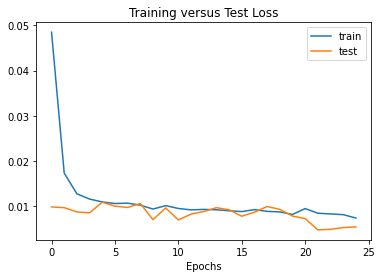

In [ ]:
# #### Final Model
model = Sequential()
# LSTM Layer
# model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2]), kernel_initializer=HeNormal(), recurrent_dropout=0.1))


# Hidden Layer (25)
model.add(Dense(25, activation='tanh', kernel_initializer=GlorotNormal()))
model.add(Dropout(0.1))

# Output Layer (1)
model.add(Dense(1, activation='tanh'))

opt = Adam(learning_rate=0.01)
model.compile(loss='mae', optimizer=opt)

history = model.fit(train_x, train_y, epochs=25, batch_size = 45, 
                    validation_data=(test_x, test_y), verbose=1, shuffle=False)

####

pyplot.plot(history.history['loss'], label = 'train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.title('Training versus Test Loss')
pyplot.xlabel('Epochs')
pyplot.show()

In [ ]:
# Sanity Check
train_x.shape, test_x.shape 

((4627, 3, 19), (1627, 3, 19))

# Evaluate Model

Prediction for Test set

In [ ]:
### Prediction
yhat = model.predict(test_x)
print("yhat shape: ", yhat.shape)
test_x = test_x.reshape((test_x.shape[0], _lookback * (_n_features-1)))

### Invert Scaling for Forecast
    # inv_yhat = concatenate((yhat, test_x[:, -(_lookback*(_n_features-1)-1):]), axis=1)
    # inv_yhat = concatenate((yhat, test_x[:, 1:]), axis=1)
inv_yhat = concatenate((test_x[:,:], yhat), axis=1)
print("inv_yhat shape: ", inv_yhat.shape)

inv_yhat = scaler.inverse_transform(inv_yhat)   # Includes both x's and y



### Inverst Scaling for Actual
test_y = test_y.reshape((len(test_y), 1))
    # inv_y = concatenate((test_y, test_x[:, -(_lookback*(_n_features-1)-1):]), axis=1)
inv_y = concatenate((test_x[:,:], test_y), axis=1)
print("inv_y shape: ", inv_y.shape)

inv_y = scaler.inverse_transform(inv_y)     # Includes both x's and y



### Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,-1], inv_yhat[:,-1]))
mae = mean_absolute_error(inv_y[:,-1], inv_yhat[:,-1])
print('Test Root Mean Squared Error = %.3f' % rmse)
print('Test Mean Absolute Error = %.3f' % mae)

yhat shape:  (1627, 1)
inv_yhat shape:  (1627, 58)
inv_y shape:  (1627, 58)
Test Root Mean Squared Error = 5466.167
Test Mean Absolute Error = 1595.208


Prediction for Training Set

In [ ]:
trainPredict = model.predict(train_x)
print("trainPredict shape: ", trainPredict.shape)

traX = train_x.reshape((train_x.shape[0], _lookback * (_n_features-1)))
inv_trainPredict = concatenate((traX[:,:], trainPredict), axis = 1)
print("inv_trainPredict shape: ", inv_trainPredict.shape)
inv_trainPredict = scaler.inverse_transform(inv_trainPredict)

traY = train_y.reshape((len(train_y), 1))
inv_trainY = concatenate((traX[:,:], traY), axis=1)
print("inv_trainY shape: ", inv_trainY.shape)
inv_trainY = scaler.inverse_transform(inv_trainY)


trainPredict shape:  (4627, 1)
inv_trainPredict shape:  (4627, 58)
inv_trainY shape:  (4627, 58)


# Combine for Final Dataset

Combine for Final DataFrame

In [ ]:
df1 = np.concatenate((inv_trainPredict, inv_yhat), axis=0)
df1.shape
df2 = np.concatenate((inv_trainY, inv_y), axis=0)
df2.shape
print(df1.shape, df2.shape)

(6254, 58) (6254, 58)


Create final dataset to export and re-attach user_id's.

In [ ]:
df_Present = pd.DataFrame(df1, columns=df_LSTM.columns, index=df_LSTM.index)
df_Present['actual'] = df2[:,-1]
df_Present['user-id'] = df_userIDs_lag
df_Present

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var14(t-3),var15(t-3),var16(t-3),var17(t-3),var18(t-3),var19(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var16(t-2),var17(t-2),var18(t-2),var19(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var1(t),actual,user-id
81,-383.278778,3.000000,1.0,1907.520020,-1916.411011,28.999998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-392.169464,2.000000,1.0,3480.340088,-3240.131592,55.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-151.961700,6.0,1.0,1462.109985,-1569.330566,23.999998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3777.433105,-259.180054,247
82,-392.168243,2.000000,1.0,3480.340088,-3240.131592,55.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-151.959793,6.000000,1.0,1462.109985,-1569.330566,23.999998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-259.180054,2.0,1.0,1592.800049,-1619.919434,39.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2899.085938,-286.301910,247
83,-151.960114,6.000000,1.0,1462.109985,-1569.330566,24.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-259.178864,2.000000,1.0,1592.800049,-1619.919434,39.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-286.301910,3.0,1.0,1785.270020,-1688.429321,47.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2094.609131,-189.460800,247
105,13858.018555,2.000000,1.0,3499.100098,-3954.261230,78.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,13402.862305,4.000000,1.0,3512.669922,-3534.660156,79.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,13380.869141,1.0,1.0,4342.120117,-4161.770508,89.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6054.884277,13561.221680,259
106,13402.862305,4.000000,1.0,3512.669922,-3534.660156,79.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,13380.869141,1.000000,1.0,4342.120117,-4161.770508,89.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13561.221680,5.0,1.0,3399.470215,-2147.988525,49.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5346.671387,14812.700195,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54979,193.958099,4.000000,0.0,4121.200195,-3067.120361,97.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1248.041748,59.000004,0.0,2669.219971,-3684.171387,123.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,233.089310,22.0,0.0,4494.020020,-3686.998291,127.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1065.767700,1040.108765,144478
54980,1248.040039,59.000000,0.0,2669.219971,-3684.171387,122.999992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,233.091812,22.000000,0.0,4494.020020,-3686.998291,127.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1040.108765,1.0,0.0,3631.179932,-4327.100098,120.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,416.962708,344.189758,144478
54981,233.091431,22.000002,0.0,4494.020020,-3686.998291,127.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1040.107910,1.000000,0.0,3631.179932,-4327.100098,120.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,344.189758,6.0,0.0,4689.899902,-4619.489258,114.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,289.042725,414.600830,144478
54982,1040.109741,1.000000,0.0,3631.179932,-4327.100098,120.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,344.189758,6.000000,0.0,4689.899902,-4619.489258,114.000000,1.0,0.0,0.0,0.0,0.0,0.0,0

Export Files

In [ ]:
# df_Present.to_csv('/content/gdrive/MyDrive/SuperModels-Data-X/SVLF_balance.csv', index=False)
# df_Present.to_csv('/content/gdrive/MyDrive/SuperModels-Data-X/SVLF_balance_ALLUSERS.csv', index=False)

# Data Visualization

We first plot our training versus validation loss.

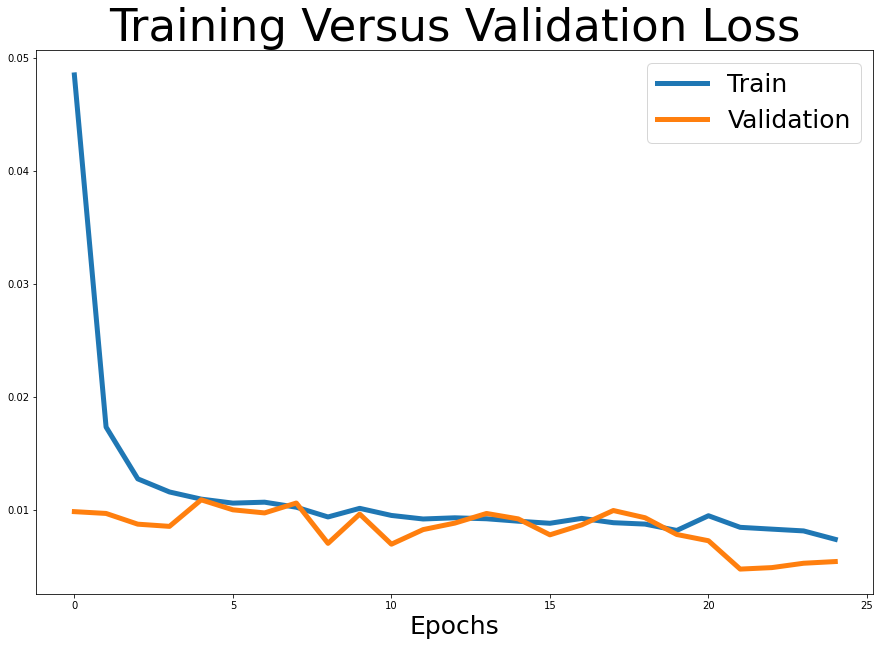

In [ ]:
pyplot.figure(figsize=(15, 10))
pyplot.rc('axes', titlesize=45)
pyplot.rc('axes', labelsize=25)
pyplot.rc('ytick', labelsize=10)
pyplot.rc('xtick', labelsize=10)
pyplot.rc('legend', fontsize=25)
pyplot.plot(history.history['loss'], label = 'Train', linewidth=5, dash_capstyle='round')
pyplot.plot(history.history['val_loss'], label='Validation', linewidth=5, dash_capstyle='round')
pyplot.legend()
pyplot.title('Training Versus Validation Loss')
pyplot.xlabel('Epochs')
pyplot.show()

Next, we present a scatter of our prediction versus actual, colored by a user's number of interactions/click with SaverLife for a given month.

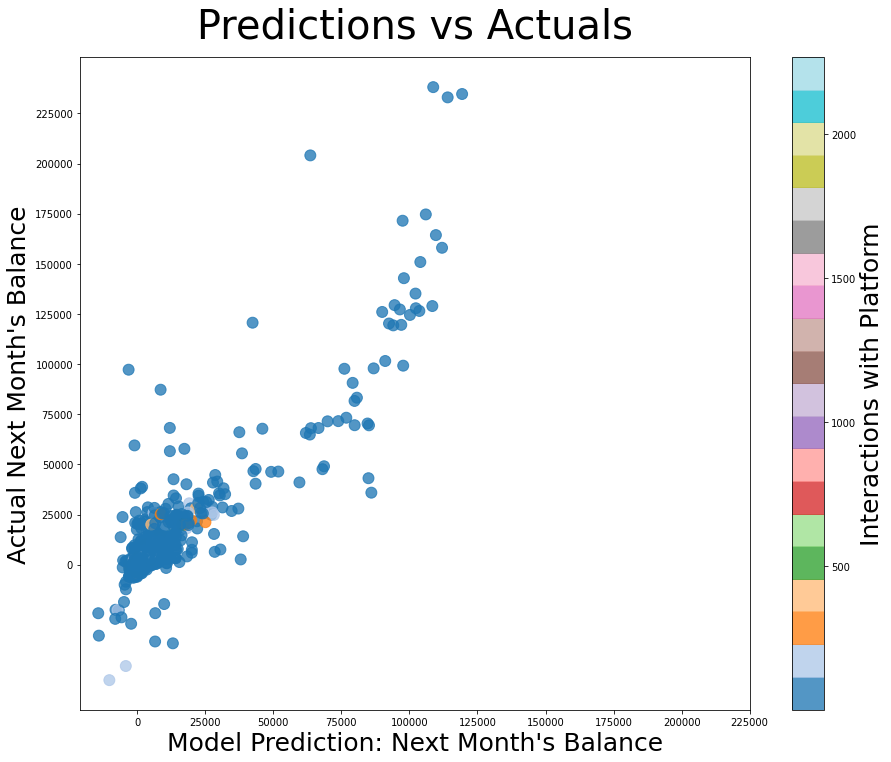

In [ ]:
df_Present.head()
pyplot.figure(figsize=(15, 12))
pyplot.rc('axes', titlesize=40)
pyplot.rc('axes', labelsize=25)
pyplot.rc('ytick', labelsize=10)
pyplot.rc('xtick', labelsize=10)

pyplot.scatter(df_Present['var1(t)'], df_Present['actual'], c=df_Present['var2(t-1)'], cmap='tab20', alpha=0.77, s=120)
pyplot.title("Predictions vs Actuals",pad=20)
pyplot.xlabel("Model Prediction: Next Month's Balance")
pyplot.ylabel("Actual Next Month's Balance")
pyplot.xticks(np.arange(0,250000,25000))
pyplot.yticks(np.arange(0,250000,25000))
cbar = pyplot.colorbar()
cbar.set_label('Interactions with Platform')


Next, we present a scatter of our prediction versus actual, colored by whether they are a Partner A user.


In [ ]:
pyplot.figure(figsize=(15, 12))
pyplot.rc('axes', titlesize=40)
pyplot.rc('axes', labelsize=25)
pyplot.rc('ytick', labelsize=10)
pyplot.rc('xtick', labelsize=10)

pyplot.scatter(df_Present['var1(t)'],df_Present['actual'], c=df_Present['var3(t-1)'], cmap='tab10', alpha=0.88, s=120)
pyplot.title("Predictions vs Actuals",pad=20)
pyplot.xlabel("Model Prediction: Next Month's Balance")
pyplot.ylabel("Actual Next Month's Balance")
pyplot.xticks(np.arange(0,250000,25000))
pyplot.yticks(np.arange(0,250000,25000))
cbar = pyplot.colorbar()
cbar.set_label('Partner A')

We look at a histogram of the distribution of monthly interactions with SaverLife across all users.

(array([   0., 2581., 2593., 1780., 1251.,  894.,  632.,  351.,  173.,
         148.,  978.,  764.,  575.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 20, 30, 40]),
 <a list of 13 Patch objects>)

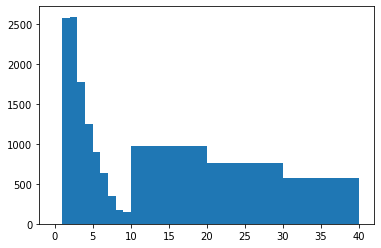

In [ ]:
pyplot.hist(dataset.events, bins=[0,1,2,3,4,5,6,7,8,9,10,20,30,40])

We also look if the number of interactions varies by balance.

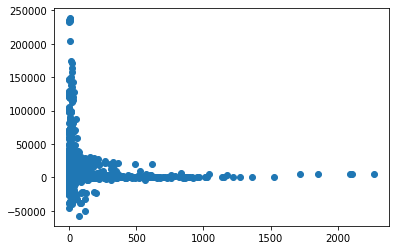

In [ ]:
pyplot.scatter(dataset['events'], dataset['balance'])

# Appendix

#### For Reference, Example of Concatenate Function

In [ ]:
a = np.array([[1, 2, 3, 4, 5],
              [11, 12, 13, 14, 15],
              [110, 120, 130, 140, 150]])
a.shape
b = np.array([[3],
              [2],
              [5],
              [6],
              [2]])
b.shape
c = np.array([[3],
              [2],
              [5]])

In [ ]:
np.dot(a, b)

array([[  56],
       [ 236],
       [2360]])

In [ ]:
d = concatenate((c, a), axis = 1)
d

array([[  3,   1,   2,   3,   4,   5],
       [  2,  11,  12,  13,  14,  15],
       [  5, 110, 120, 130, 140, 150]])